# **Practice Lab: ResNet architecture for Intel Image Classification** 

We will use a ResNet architecture to solve an imagery classification problem. You
have to work with the Intel Image Classification, which consists of 6 classes with 25k samples.


# Outline
- [Packages ](#1)
- [Loading Data ](#2)
  - [Dataset overview](#2.1)
- [Modeling](#3)
  - [Training and Testing Function](#3.1)
  - [ResNet](#3.1)
- [Evaluating](#4)

<a name="1"></a>
## 1 - **Packages** 

In [10]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFilter
from sklearn.preprocessing import LabelEncoder
import timeit
import cv2 as cv2
import argparse
from sklearn.utils import shuffle

#Neural Network packages

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torchvision import models
from torch.autograd import Variable

**Using kaggle this time**

In [2]:
os.getcwd()

'/kaggle/working'

**GPU P100**

In [3]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device, torch.cuda.get_device_name(0))

cuda Tesla P100-PCIE-16GB


<a name="2"></a>
## 2 - **Loading Data and Transform it** 



In [49]:
transform0 = transforms.Compose([transforms.Resize(256),
                                transforms.RandomHorizontalFlip(),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0,0,0], 
                                                    [1,1,1])])



In [54]:
transform1 = transforms.Compose([transforms.Resize(256),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(degrees=[0,90]),
                                transforms.CenterCrop(224),
                                #transforms.TenCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0,0,0], 
                                                    [1,1,1])])



In [5]:
# Custom Dataset Class
class INTELDataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
   
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        image = image.convert('RGB')
        #image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    
    
    def __len__(self):
        return len(self.img_data)
         

# ***Plotting Data***

In [8]:
def get_images(directory):
    Images = []
    Labels = []  
    label = 0
    for labels in os.listdir(".//Dataset/seg_train/seg_train"): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(".//Dataset/seg_train/seg_train/"+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(".//Dataset/seg_train/seg_train/"+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [11]:
Images, Labels = get_images('../input/seg_train/seg_train/') #Extract the training images from the folders.

TrainImages = np.array(Images) #converting the list of images to numpy array.
TrainLabels = np.array(Labels)

In [12]:
Labels = [ "Building",
          "forest",
          "glacier",
          "mountain",
          "Sea",
          "Street"
]

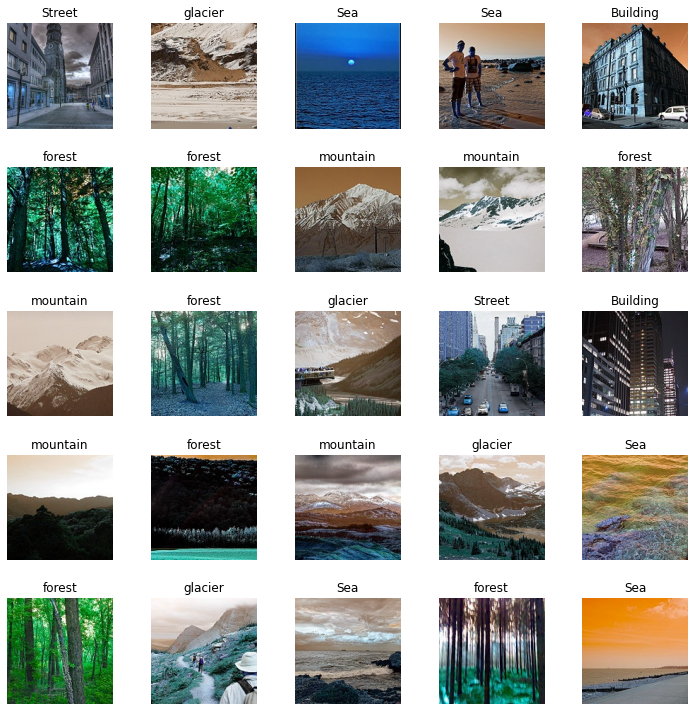

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
X = TrainImages
fig, axes = plt.subplots(5,5, figsize=(10,10))
fig.tight_layout(pad=0.1)

for i,ax in enumerate(axes.flat):
    random_index = np.random.randint(14034)
    ax.imshow(X[random_index], cmap='gray')
    ax.set_title(Labels[int(TrainLabels[random_index])])
    ax.set_axis_off()

# ***Creating training data labels***

In [6]:
trainingPath = '../input/intel-image-classification/seg_train'
testingPath  = '../input/intel-image-classification/seg_test'

seperate labels and images then convert it to a dataframe !

In [8]:
images_train=[]
labels_train=[]


for file in os.listdir(os.path.join(trainingPath,'seg_train')):
  if file=='buildings':
    for img in os.listdir(os.path.join(trainingPath,'seg_train', file)):
      images_train.append(img)
      labels_train.append('buildings')
  if file=='forest':
    for img in os.listdir(os.path.join(trainingPath,'seg_train', file)):
      images_train.append(img)
      labels_train.append('forest')      
  if file=='glacier':
    for img in os.listdir(os.path.join(trainingPath,'seg_train', file)):
      images_train.append(img)
      labels_train.append('glacier')
  if file=='mountain':
    for img in os.listdir(os.path.join(trainingPath,'seg_train', file)):
      images_train.append(img)
      labels_train.append('mountain')  
  if file=='sea':
    for img in os.listdir(os.path.join(trainingPath,'seg_train', file)):
      images_train.append(img)
      labels_train.append('sea')  
  if file=='street':
    for img in os.listdir(os.path.join(trainingPath,'seg_train', file)):
      images_train.append(img)
      labels_train.append('street')      

data_train= {'Images': images_train, 'labels':labels_train}     
data_train=pd.DataFrame(data_train)
print(data_train.head(15))
        

       Images    labels
0   14986.jpg  mountain
1    3138.jpg  mountain
2    1700.jpg  mountain
3   16257.jpg  mountain
4    2863.jpg  mountain
5     771.jpg  mountain
6   12167.jpg  mountain
7   17643.jpg  mountain
8    6560.jpg  mountain
9   10162.jpg  mountain
10   4009.jpg  mountain
11  15823.jpg  mountain
12    820.jpg  mountain
13   6272.jpg  mountain
14  15783.jpg  mountain


Convert string labels to int

In [9]:
encoder= LabelEncoder()
data_train['encoded_labels']= encoder.fit_transform(data_train['labels'])
data_train.head(15)
data_train.encoded_labels.value_counts()

3    2512
2    2404
5    2382
4    2274
1    2271
0    2191
Name: encoded_labels, dtype: int64

In [11]:
train_batch_size =32
random_seed      =50

In [12]:
# Create train sampler
train_indices = list(range(len(data_train)))

train_sampler = SubsetRandomSampler(train_indices)


In [13]:
#training image path
path_train=os.path.join(trainingPath,'seg_train')
print(path_train)

../input/intel-image-classification/seg_train/seg_train


In [55]:
dataset_train = INTELDataset(data_train,path_train,transform1)



train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=train_batch_size, 
                                           sampler=train_sampler)


**Now for the testingSet**

In [15]:
images_test=[]
labels_test=[]


for file in os.listdir(os.path.join(testingPath,'seg_test')):
  if file=='buildings':
    for img in os.listdir(os.path.join(testingPath,'seg_test', file)):
      images_test.append(img)
      labels_test.append('buildings')
  if file=='forest':
    for img in os.listdir(os.path.join(testingPath,'seg_test', file)):
      images_test.append(img)
      labels_test.append('forest')      
  if file=='glacier':
    for img in os.listdir(os.path.join(testingPath,'seg_test', file)):
      images_test.append(img)
      labels_test.append('glacier')
  if file=='mountain':
    for img in os.listdir(os.path.join(testingPath,'seg_test', file)):
      images_test.append(img)
      labels_test.append('mountain')  
  if file=='sea':
    for img in os.listdir(os.path.join(testingPath,'seg_test', file)):
      images_test.append(img)
      labels_test.append('sea')  
  if file=='street':
    for img in os.listdir(os.path.join(testingPath,'seg_test', file)):
      images_test.append(img)
      labels_test.append('street')      

data_test= {'Images': images_test, 'labels':labels_test}     
data_test=pd.DataFrame(data_test)
print(data_test.head(10))
        

      Images    labels
0  22608.jpg  mountain
1  23274.jpg  mountain
2  23775.jpg  mountain
3  22046.jpg  mountain
4  23436.jpg  mountain
5  20684.jpg  mountain
6  20554.jpg  mountain
7  21093.jpg  mountain
8  24287.jpg  mountain
9  20762.jpg  mountain


In [16]:
encoder= LabelEncoder()
data_test['encoded_labels']= encoder.fit_transform(data_test['labels'])
data_test.head(10)
data_test.encoded_labels.value_counts()

2    553
3    525
4    510
5    501
1    474
0    437
Name: encoded_labels, dtype: int64

In [17]:
path_test=os.path.join(testingPath,'seg_test')


In [18]:
# Creating Test Sampler
test_indices = list(range(len(data_test)))

test_sampler = SubsetRandomSampler(test_indices)


In [19]:
test_batch_size=20

In [56]:
dataset_test = INTELDataset(data_test,path_test,transform1)



test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=test_batch_size, 
                                           sampler=test_sampler)


<a name="3.1"></a>
# ***Function for Training***

In [21]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.cuda()
    model.train()
    train_losses=[]
    for batch_idx, (data, target) in enumerate(train_loader):
       
        # send the image, target to the device
        data, target = data.to(device), target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use cross entropy in pytorch)
        loss = criterion(output, target)
        #appending train loss list
        train_losses.append(loss.item())
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
     
        if batch_idx % 32 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    return train_losses

# ***Function for Testing***

In [22]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          
            # send the image, target to the device
            data, target = data.to(device), target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            #print(output)
         
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    #print(output)
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# ***Training and Testing using pretrained Resnet50***

In [ ]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_features= model.fc.in_features
model.fc = nn.Linear(num_features, 6)


criterion = nn.CrossEntropyLoss().cuda()
#Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)

start = timeit.default_timer()
for epoch in range(1, 11):
    train(model, device, train_loader, criterion, optimizer, epoch)
    test(model, device, test_loader, criterion)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

In [46]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_features= model.fc.in_features
model.fc = nn.Linear(num_features, 6)


criterion = nn.CrossEntropyLoss().cuda()
#Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)

start = timeit.default_timer()
for epoch in range(1, 11):
    train(model, device, train_loader, criterion, optimizer, epoch)
    test(model, device, test_loader, criterion)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/14034 (0%)]	Loss: 1.830000
Train Epoch: 1 [1024/14034 (7%)]	Loss: 0.768932
Train Epoch: 1 [2048/14034 (15%)]	Loss: 1.148619
Train Epoch: 1 [3072/14034 (22%)]	Loss: 0.556057
Train Epoch: 1 [4096/14034 (29%)]	Loss: 0.502832
Train Epoch: 1 [5120/14034 (36%)]	Loss: 0.633436
Train Epoch: 1 [6144/14034 (44%)]	Loss: 0.541143
Train Epoch: 1 [7168/14034 (51%)]	Loss: 1.178295
Train Epoch: 1 [8192/14034 (58%)]	Loss: 0.705637
Train Epoch: 1 [9216/14034 (66%)]	Loss: 0.585259
Train Epoch: 1 [10240/14034 (73%)]	Loss: 0.846293
Train Epoch: 1 [11264/14034 (80%)]	Loss: 1.050159
Train Epoch: 1 [12288/14034 (87%)]	Loss: 1.283498
Train Epoch: 1 [13312/14034 (95%)]	Loss: 0.517139

Test set: Average loss: 0.0496, Accuracy: 2202/3000 (73%)

Train Epoch: 2 [0/14034 (0%)]	Loss: 1.644198
Train Epoch: 2 [1024/14034 (7%)]	Loss: 0.485926
Train Epoch: 2 [2048/14034 (15%)]	Loss: 0.941686
Train Epoch: 2 [3072/14034 (22%)]	Loss: 0.935783
Train Epoch: 2 [4096/14034 (29%)]	Loss: 1.350318
Train Epoch: 2 

In [57]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_features= model.fc.in_features
model.fc = nn.Linear(num_features, 6)


criterion = nn.CrossEntropyLoss().cuda()
#Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)

start = timeit.default_timer()
for epoch in range(1, 11):
    train(model, device, train_loader, criterion, optimizer, epoch)
    test(model, device, test_loader, criterion)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/14034 (0%)]	Loss: 1.821805
Train Epoch: 1 [1024/14034 (7%)]	Loss: 0.370200
Train Epoch: 1 [2048/14034 (15%)]	Loss: 1.337283
Train Epoch: 1 [3072/14034 (22%)]	Loss: 0.556116
Train Epoch: 1 [4096/14034 (29%)]	Loss: 0.804838
Train Epoch: 1 [5120/14034 (36%)]	Loss: 1.477892
Train Epoch: 1 [6144/14034 (44%)]	Loss: 0.474627
Train Epoch: 1 [7168/14034 (51%)]	Loss: 0.655048
Train Epoch: 1 [8192/14034 (58%)]	Loss: 0.985758
Train Epoch: 1 [9216/14034 (66%)]	Loss: 1.121586
Train Epoch: 1 [10240/14034 (73%)]	Loss: 0.555382
Train Epoch: 1 [11264/14034 (80%)]	Loss: 1.009061
Train Epoch: 1 [12288/14034 (87%)]	Loss: 1.363163
Train Epoch: 1 [13312/14034 (95%)]	Loss: 1.116066

Test set: Average loss: 0.0286, Accuracy: 2495/3000 (83%)

Train Epoch: 2 [0/14034 (0%)]	Loss: 0.751358
Train Epoch: 2 [1024/14034 (7%)]	Loss: 1.222518
Train Epoch: 2 [2048/14034 (15%)]	Loss: 2.090687
Train Epoch: 2 [3072/14034 (22%)]	Loss: 0.521674
Train Epoch: 2 [4096/14034 (29%)]	Loss: 1.461105
Train Epoch: 2 

In [58]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_features= model.fc.in_features
model.fc = nn.Linear(num_features, 6)


criterion = nn.CrossEntropyLoss().cuda()
#Define Adam Optimiser with a learning rate of 0.005
optimizer = optim.Adam(model.fc.parameters(), lr=0.005)

start = timeit.default_timer()
for epoch in range(1, 11):
    train(model, device, train_loader, criterion, optimizer, epoch)
    test(model, device, test_loader, criterion)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/14034 (0%)]	Loss: 1.717109
Train Epoch: 1 [1024/14034 (7%)]	Loss: 0.777127
Train Epoch: 1 [2048/14034 (15%)]	Loss: 0.626964
Train Epoch: 1 [3072/14034 (22%)]	Loss: 0.624273
Train Epoch: 1 [4096/14034 (29%)]	Loss: 0.360270
Train Epoch: 1 [5120/14034 (36%)]	Loss: 0.379281
Train Epoch: 1 [6144/14034 (44%)]	Loss: 0.882145
Train Epoch: 1 [7168/14034 (51%)]	Loss: 0.588367
Train Epoch: 1 [8192/14034 (58%)]	Loss: 0.573616
Train Epoch: 1 [9216/14034 (66%)]	Loss: 0.585919
Train Epoch: 1 [10240/14034 (73%)]	Loss: 0.716255
Train Epoch: 1 [11264/14034 (80%)]	Loss: 1.128740
Train Epoch: 1 [12288/14034 (87%)]	Loss: 0.419357
Train Epoch: 1 [13312/14034 (95%)]	Loss: 0.287916

Test set: Average loss: 0.0276, Accuracy: 2475/3000 (82%)

Train Epoch: 2 [0/14034 (0%)]	Loss: 0.294059
Train Epoch: 2 [1024/14034 (7%)]	Loss: 0.455158
Train Epoch: 2 [2048/14034 (15%)]	Loss: 0.454901
Train Epoch: 2 [3072/14034 (22%)]	Loss: 0.942425
Train Epoch: 2 [4096/14034 (29%)]	Loss: 0.556668
Train Epoch: 2 

In [ ]:
model = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=6)

In [40]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<a name="4"></a>
# ***Validate the Model***

In [59]:
valid_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [115]:

def predict_image(image):
    image_tensor = valid_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    vector={0:'buildings',1:'forest',2:'glacier',3:'mountain',4:'sea',5:'street'}
    obj=vector[index]
    
        
    return obj

In [116]:
lis= [
    "../input/intel-image-classification/seg_pred/seg_pred/10004.jpg",
    "../input/intel-image-classification/seg_pred/seg_pred/10043.jpg",
    "../input/intel-image-classification/seg_pred/seg_pred/10045.jpg",
    "../input/intel-image-classification/seg_pred/seg_pred/10054.jpg",
    "../input/intel-image-classification/seg_pred/seg_pred/1008.jpg",
    "../input/intel-image-classification/seg_pred/seg_pred/10059.jpg",
    "../input/intel-image-classification/seg_pred/seg_pred/10069.jpg",
]




In [86]:
for image in lis:
    im = Image.open(image)
    print(predict_image(im))
    im

street
sea
street
glacier
street
forest
sea


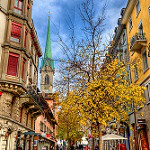

In [130]:
im0 = Image.open(lis[0])
im0

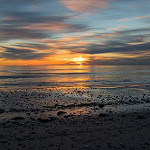

In [131]:
im1 = Image.open(lis[1])
im1

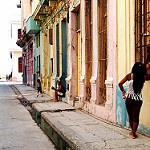

In [132]:
im1 = Image.open(lis[2])
im1

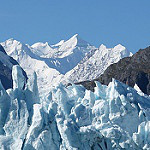

In [133]:
im1 = Image.open(lis[3])
im1

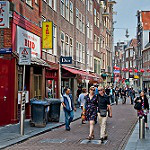

In [134]:
im1 = Image.open(lis[4])
im1

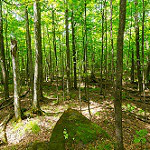

In [135]:
im1 = Image.open(lis[5])
im1

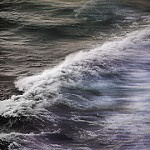

In [136]:
im1 = Image.open(lis[6])
im1

In [137]:
pred_path='../input/intel-image-classification/seg_pred'
valid_path=os.path.join(pred_path,'seg_pred')